In [3]:
import pandas as pd
from scipy import stats
from sklearn.metrics import roc_auc_score
from scipy.signal import correlate
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split


ModuleNotFoundError: No module named 'xgboost'

| Metric                      | Thresholds (Rule of Thumb)                                                                                  | Meaning                                                                     |
| --------------------------- | ----------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------- |
| **p-value**                 | < 0.05 → significant  <br> ≥ 0.05 → not significant                                                         | Is the difference between fault vs non-fault **real** or just random noise? |
| **Cohen’s d** (effect size) | 0.2 = small  <br> 0.5 = medium  <br> 0.8+ = large                                                           | How **big** the difference is between the two groups.                       |
| **AUC**                     | 0.5 = random (useless) <br> 0.6–0.7 = weak  <br> 0.7–0.8 = fair  <br> 0.8–0.9 = good  <br> >0.9 = excellent | How well the feature can **separate fault vs non-fault**.                   |


📌 How to Decide if a Feature is Useful

Check p-value

If ≥ 0.05 → ignore the feature (no significant difference).

If < 0.05 → continue.

Check effect size (Cohen’s d)

d < 0.2 → trivial difference → probably useless.

d ≥ 0.2 → meaningful → keep candidate.

Check discrimination (AUC)

AUC < 0.6 → poor, feature is weak.

AUC 0.6–0.7 → weak but may help when combined.

AUC ≥ 0.7 → strong candidate feature.

In [ ]:
df_joint0_stop = pd.read_csv('Dataset\joint_0_features (1) stop.csv')
df_joint0_stop.head()

,Num,Timestamp,Current_J0,Temperature_T0,Speed_J0,Tool_current,cycle,Robot_ProtectiveStop
0,1,2022-10-26T08:17:21.847Z,0.109628,27.875,2.955651e-01,0.082732,1,0.0
1,2,2022-10-26T08:17:22.852Z,0.595605,27.875,-7.390000e-30,0.505895,1,0.0
2,3,2022-10-26T08:17:23.857Z,-0.229474,27.875,1.369386e-01,0.079420,1,0.0
3,4,2022-10-26T08:17:24.863Z,0.065053,27.875,-9.030032e-02,0.083325,1,0.0
4,5,2022-10-26T08:17:25.877Z,0.884140,27.875,1.268088e-01,0.086379,1,0.0


In [ ]:
df_joint0_grip = pd.read_csv('Dataset\joint_0_features (1)_grip.csv')
df_joint0_grip.head()

,Num,Timestamp,Current_J0,Temperature_T0,Speed_J0,Tool_current,cycle,grip_lost
0,1,2022-10-26T08:17:21.847Z,0.109628,27.875,2.955651e-01,0.082732,1,False
1,2,2022-10-26T08:17:22.852Z,0.595605,27.875,-7.390000e-30,0.505895,1,False
2,3,2022-10-26T08:17:23.857Z,-0.229474,27.875,1.369386e-01,0.079420,1,False
3,4,2022-10-26T08:17:24.863Z,0.065053,27.875,-9.030032e-02,0.083325,1,False
4,5,2022-10-26T08:17:25.877Z,0.884140,27.875,1.268088e-01,0.086379,1,False


In [ ]:
def convert_to_timestamp(df):
    df["Timestamp"] = df["Timestamp"].str.replace('"', '', regex=False)

    df["Timestamp"] = pd.to_datetime(df["Timestamp"], utc=True, errors="coerce")

In [ ]:

def remove_strip(df):
        df.columns = df.columns.str.strip()
        return df

df_joint0_stop=remove_strip(df_joint0_stop)
df_joint0_grip=remove_strip(df_joint0_grip)        


In [ ]:
def fill_null_with_fandb(df):
    clean_data = df.groupby('cycle').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
    return clean_data

In [ ]:
df_joint0_stop_clean=fill_null_with_fandb(df_joint0_stop)
df_joint0_grip_clean=fill_null_with_fandb(df_joint0_grip)
df_joint0_grip_clean.isnull().sum()

C:\Users\youss\AppData\Local\Temp\ipykernel_20060\428220627.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  clean_data = df.groupby('cycle').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
C:\Users\youss\AppData\Local\Temp\ipykernel_20060\428220627.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clean_data = df.groupby('cycle').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
C:\Users\youss\AppData\Local\Temp\ipykernel_20060\428220627.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() inste

Num               0
Timestamp         0
Current_J0        0
Temperature_T0    0
Speed_J0          0
Tool_current      0
cycle             0
grip_lost         0
dtype: int64

In [ ]:
def add_robot_features(df, dt=1.0, window=5):
    df = df.copy()

    curr_cols = [c for c in df.columns if c.startswith('Current_J')]
    spd_cols  = [c for c in df.columns if c.startswith('Speed_J')]
    tmp_cols  = [c for c in df.columns if c.startswith('Temperature')]

    # Loop joints (J0..J5)
    for j in range(6):
        c, s = f'Current_J{j}', f'Speed_J{j}'
        if c in df and s in df:
            # Absolute values
            df[f'abs_{c}'] = df[c].abs()
            df[f'abs_{s}'] = df[s].abs()

            # Sudden change (derivative)
            df[f'sudden{j}'] = df[s].diff() / dt

            # Power (approx)
            df[f'power_J{j}'] = df[c].abs() * df[s].abs()

            # Rolling means
            df[f'speed{j}_roll_mean'] = df[s].rolling(window).mean()
            df[f'current{j}_roll_mean'] = df[c].rolling(window).mean()

    # --- Extra engineered features (global, not per joint) ---
    if "Tool_current" in df and "Current_J5" in df:
        df["ratio_tool_current"] = df["Tool_current"] / (df["Current_J5"] + 1e-6)
    if "Temperature_J5" in df and "Current_J5" in df:
        df["temp_per_current"] = df["Temperature_J5"] / (df["Current_J5"] + 1e-6)
    if "Speed_J5" in df and "Current_J5" in df:
        df["speed_per_current"] = df["Speed_J5"] / (df["Current_J5"] + 1e-6)
    if {"Current_J5","Temperature_J5","Speed_J5"} <= set(df.columns):
        df["interaction_all"] = df["Current_J5"] * df["Temperature_J5"] * df["Speed_J5"]
    if {"Current_J5","Tool_current","Speed_J5"} <= set(df.columns):
        df["load_efficiency"] = (df["Current_J5"] + df["Tool_current"]) / (df["Speed_J5"] + 1e-6)

    return df


In [ ]:


def univariate_analysis(df, features, target):
    y = df[target].astype(int).values
    results = []
    for f in features:
        x = df[f].values
     
        x0, x1 = x[y==0], x[y==1]
        
        t, p = stats.ttest_ind(x0, x1, equal_var=False, nan_policy="omit")
        
        s0, s1 = x0.std(ddof=1), x1.std(ddof=1)
        sp = np.sqrt(((len(x0)-1)*s0**2 + (len(x1)-1)*s1**2) / (len(x0)+len(x1)-2))
        d = (x1.mean() - x0.mean()) / sp if sp > 0 else np.nan
        
        auc = roc_auc_score(y, x) if len(np.unique(y)) == 2 else np.nan
        results.append({
            "feature": f,
            "mean_no_fault": np.mean(x0),
            "mean_fault": np.mean(x1),
            "cohens_d": d,
            "t_stat": t,
            "p_value": p,
            "AUC": auc
        })
    return pd.DataFrame(results).sort_values("p_value")






In [ ]:
df_joint1=pd.read_csv('Dataset/joint_1_features (1).csv')
df_j2=pd.read_csv('Dataset/joint_2_features (1).csv')
df_j3=pd.read_csv("Dataset/joint_3_features (2).csv")
df_j4=pd.read_csv("Dataset/joint_4_features (1).csv")
df_j5=pd.read_csv("Dataset/joint_5_features (1) (1).csv")


In [ ]:
convert_to_timestamp(df_joint1)
convert_to_timestamp(df_j2)
convert_to_timestamp(df_j3)
convert_to_timestamp(df_j4)
convert_to_timestamp(df_j5)

In [ ]:
remove_strip(df_joint1)
remove_strip(df_j2)
remove_strip(df_j3)
remove_strip(df_j4)
remove_strip(df_j5)

,Num,Timestamp,Current_J5,Temperature_J5,Speed_J5,Tool_current,cycle,Robot_ProtectiveStop,grip_lost
0,1,2022-10-26 08:17:21.847000+00:00,-0.152622,32.0000,-0.152962,0.082732,1,0.0,False
1,2,2022-10-26 08:17:22.852000+00:00,-0.260764,32.0000,0.000417,0.505895,1,0.0,False
2,3,2022-10-26 08:17:23.857000+00:00,0.039071,32.0625,-0.496856,0.079420,1,0.0,False
3,4,2022-10-26 08:17:24.863000+00:00,0.153903,32.0000,0.425559,0.083325,1,0.0,False
4,5,2022-10-26 08:17:25.877000+00:00,0.178998,32.0000,0.180989,0.086379,1,0.0,False
...,...,...,...,...,...,...,...,...,...
7404,7405,2022-10-26 15:36:02.555000+00:00,0.023025,44.5625,0.000000,0.080013,264,0.0,False
7405,7406,2022-10-26 15:36:03.562000+00:00,0.047794,44.5000,0.000000,0.078740,264,0.0,False
7406,7407,2022-10-26 15:36:04.571000+00:00,0.028567,44.5000,0.000000,0.091471,264,0.0,False
7407,7408,2022-10-26 15:36:05.572000+00:00,0.049641,44.5625,0.000000,0.090026,264,0.0,False


In [ ]:
df_joint1=fill_null_with_fandb(df_joint1)
df_joint2=fill_null_with_fandb(df_j2)
df_joint3=fill_null_with_fandb(df_j3)
df_joint4=fill_null_with_fandb(df_j4)
df_joint5=fill_null_with_fandb(df_j5)

C:\Users\youss\AppData\Local\Temp\ipykernel_20060\428220627.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  clean_data = df.groupby('cycle').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
C:\Users\youss\AppData\Local\Temp\ipykernel_20060\428220627.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clean_data = df.groupby('cycle').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
C:\Users\youss\AppData\Local\Temp\ipykernel_20060\428220627.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() inste

In [ ]:
df_joint0_stop_clean=add_robot_features(df_joint0_stop_clean)
df_joint0_grip_clean=add_robot_features(df_joint0_grip_clean)
df_joint1=add_robot_features(df_joint1)
df_joint2=add_robot_features(df_joint2)
df_joint3=add_robot_features(df_joint3)
df_joint4=add_robot_features(df_joint4)
df_joint5=add_robot_features(df_joint5)   

In [ ]:
df_joint0_stop_clean.isnull().sum()

Num                     0
Timestamp               0
Current_J0              0
Temperature_T0          0
Speed_J0                0
Tool_current            0
cycle                   0
Robot_ProtectiveStop    0
abs_Current_J0          0
abs_Speed_J0            0
sudden0                 1
power_J0                0
speed0_roll_mean        4
current0_roll_mean      4
dtype: int64

In [ ]:
df_joint0_stop_clean["sudden0"].fillna(df_joint0_stop_clean["sudden0"].mean(), inplace=True)
df_joint0_grip_clean["sudden0"].fillna(df_joint0_grip_clean["sudden0"].mean(), inplace=True)
df_joint1["sudden1"].fillna(df_joint1["sudden1"].mean(), inplace=True)
df_joint2["sudden2"].fillna(df_joint2["sudden2"].mean(), inplace=True)
df_joint3["sudden3"].fillna(df_joint3["sudden3"].mean(), inplace=True)
df_joint4["sudden4"].fillna(df_joint4["sudden4"].mean(), inplace=True)
df_joint5["sudden5"].fillna(df_joint5["sudden5"].mean(), inplace=True)

C:\Users\youss\AppData\Local\Temp\ipykernel_20060\3349680284.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_joint0_stop_clean["sudden0"].fillna(df_joint0_stop_clean["sudden0"].mean(), inplace=True)
C:\Users\youss\AppData\Local\Temp\ipykernel_20060\3349680284.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

In [ ]:
df_joint0_stop_clean["speed0_roll_mean"].fillna(df_joint0_stop_clean["speed0_roll_mean"].mean(), inplace=True)
df_joint0_stop_clean["current0_roll_mean"].fillna(df_joint0_stop_clean["current0_roll_mean"].mean(), inplace=True)
df_joint0_grip_clean["speed0_roll_mean"].fillna(df_joint0_grip_clean["speed0_roll_mean"].mean(), inplace=True)
df_joint0_grip_clean["current0_roll_mean"].fillna(df_joint0_grip_clean["current0_roll_mean"].mean(), inplace=True)
df_joint1["speed1_roll_mean"].fillna(df_joint1["speed1_roll_mean"].mean(), inplace=True)
df_joint1["current1_roll_mean"].fillna(df_joint1["current1_roll_mean"].mean(), inplace=True)
df_joint2["speed2_roll_mean"].fillna(df_joint2["speed2_roll_mean"].mean(), inplace=True)
df_joint2["current2_roll_mean"].fillna(df_joint2["current2_roll_mean"].mean(), inplace=True)
df_joint3["speed3_roll_mean"].fillna(df_joint3["speed3_roll_mean"].mean(), inplace=True)
df_joint3["current3_roll_mean"].fillna(df_joint3["current3_roll_mean"].mean(), inplace=True)
df_joint4["speed4_roll_mean"].fillna(df_joint4["speed4_roll_mean"].mean(), inplace=True)
df_joint4["current4_roll_mean"].fillna(df_joint4["current4_roll_mean"].mean(), inplace=True)

df_joint5["speed5_roll_mean"].fillna(df_joint5["speed5_roll_mean"].mean(), inplace=True)
df_joint5["current5_roll_mean"].fillna(df_joint5["current5_roll_mean"].mean(), inplace=True)


C:\Users\youss\AppData\Local\Temp\ipykernel_20060\1880026115.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_joint0_stop_clean["speed0_roll_mean"].fillna(df_joint0_stop_clean["speed0_roll_mean"].mean(), inplace=True)
C:\Users\youss\AppData\Local\Temp\ipykernel_20060\1880026115.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on 

In [ ]:
df_joint0_stop_clean.head()

Num                 Timestamp  Current_J0  Temperature_T0  \
cycle                                                                
1     0    1  2022-10-26T08:17:21.847Z    0.109628          27.875   
      1    2  2022-10-26T08:17:22.852Z    0.595605          27.875   
      2    3  2022-10-26T08:17:23.857Z   -0.229474          27.875   
      3    4  2022-10-26T08:17:24.863Z    0.065053          27.875   
      4    5  2022-10-26T08:17:25.877Z    0.884140          27.875   

             Speed_J0  Tool_current  cycle  Robot_ProtectiveStop  \
cycle                                                              
1     0  2.955651e-01      0.082732      1                   0.0   
      1 -7.390000e-30      0.505895      1                   0.0   
      2  1.369386e-01      0.079420      1                   0.0   
      3 -9.030032e-02      0.083325      1                   0.0   
      4  1.268088e-01      0.086379      1                   0.0   

         abs_Current_J0  abs_Speed_J0   sudden0      power_J0  \
cycle                                                           
1     0        0.109628  2.955651e-01 -0.000040  3.240209e-02   
      1        0.595605  7.390000e-30 -0.295565  4.401522e-30   
      2        0.229474  1.369386e-01  0.136939  3.142382e-02   
      3        0.065053  9.030032e-02 -0.227239  5.874323e-03   
      4        0.884140  1.268088e-01  0.217109  1.121168e-01   

         speed0_roll_mean  current0_roll_mean  
cycle                                          
1     0          0.001815           -0.048254  
      1          0.001815           -0.048254  
      2          0.001815           -0.048254  
      3          0.001815           -0.048254  
      4          0.093802            0.284990

In [ ]:

features = ["Current_J0","Temperature_T0","Speed_J0","Tool_current","abs_Current_J0","abs_Speed_J0","sudden0","power_J0","speed0_roll_mean","current0_roll_mean"]
uni_stop = univariate_analysis(df_joint0_stop_clean, features, "Robot_ProtectiveStop")
uni_stop

,feature,mean_no_fault,mean_fault,cohens_d,t_stat,p_value,AUC
5,abs_Speed_J0,0.073784,0.009527,-0.493558,23.531649,9.237980e-88,0.334439
7,power_J0,0.025056,0.004641,-0.373816,13.664739,1.636070e-35,0.337293
3,Tool_current,0.110511,0.088449,-0.279074,8.781327,5.679781e-17,0.419020
1,Temperature_T0,34.884283,35.730063,0.307080,-6.138063,2.530407e-09,0.593254
4,abs_Current_J0,0.377315,0.235823,-0.189761,4.215518,3.242020e-05,0.364578
2,Speed_J0,0.002116,-0.004915,-0.047201,2.417429,1.587951e-02,0.467948
0,Current_J0,-0.051095,0.025440,0.091966,-2.087744,3.760191e-02,0.565948
6,sudden0,0.000085,-0.003243,-0.015676,0.428180,6.687844e-01,0.479029
9,current0_roll_mean,-0.047885,-0.057699,-0.027832,0.409708,6.823170e-01,0.513440
8,speed0_roll_mean,0.001839,0.001191,-0.011103,0.166941,8.675307e-01,0.501023


In [ ]:

uni_grip = univariate_analysis(df_joint0_grip_clean, features, "grip_lost")
uni_grip

,feature,mean_no_fault,mean_fault,cohens_d,t_stat,p_value,AUC
1,Temperature_T0,34.960630,33.603909,-0.493646,5.930738,9.905253e-09,0.402044
7,power_J0,0.024599,0.015108,-0.173424,5.413614,1.198579e-07,0.546177
3,Tool_current,0.110131,0.096362,-0.174017,4.621603,5.669026e-06,0.495374
4,abs_Current_J0,0.375206,0.277060,-0.131578,2.776960,5.863169e-03,0.476163
2,Speed_J0,0.001235,0.020005,0.126033,-2.490364,1.336036e-02,0.566018
9,current0_roll_mean,-0.050079,0.005567,0.157863,-2.447415,1.505297e-02,0.552507
8,speed0_roll_mean,0.001538,0.009979,0.144492,-2.176715,3.040865e-02,0.544138
6,sudden0,-0.000570,0.015601,0.076167,-1.640820,1.019685e-01,0.542892
0,Current_J0,-0.050048,0.005904,0.067228,-1.405197,1.610915e-01,0.514501
5,abs_Speed_J0,0.071277,0.073923,0.020232,-0.446117,6.558588e-01,0.574373


In [ ]:
from sklearn.metrics import roc_curve

def wilson_ci(k, n, z=1.96):
    if n == 0: return (np.nan, np.nan)
    p = k/n
    denom = 1 + z**2/n
    centre = p + z**2/(2*n)
    adj = z*np.sqrt((p*(1-p) + z**2/(4*n))/n)
    lo = (centre - adj)/denom
    hi = (centre + adj)/denom
    return lo, hi

def youden_threshold(x, y):
    fpr, tpr, thr = roc_curve(y.astype(int), x)
    j = tpr - fpr
    i = np.nanargmax(j)
    return thr[i], tpr[i], 1 - fpr[i]

def fault_rate_bins(df, feature, target, bins=12, min_count=30, quantile_bins=True):
    s = df[[feature, target]].dropna()

  
    if quantile_bins:
        binned = pd.qcut(s[feature], q=bins, duplicates='drop')
    else:
        binned = pd.cut(s[feature], bins=bins)

   
    g = s.groupby(binned, observed=True)[target]
    count  = g.count()
    faults = g.sum()
    rate   = faults / count

    mids = np.array([iv.mid for iv in count.index])

 
    mask = (count >= min_count)
    if hasattr(mask, "fillna"):
        mask = mask.fillna(False)
    mask = np.asarray(mask, dtype=bool)

 
    if not mask.any():
        
        keep_idx = np.argsort(count.values)[-min(6, len(count)):]
        mask = np.zeros(len(count), dtype=bool)
        mask[keep_idx] = True

    mids  = mids[mask]
    rate  = rate.to_numpy()[mask]
    n     = count.to_numpy()[mask]
    f     = faults.to_numpy()[mask]

    ci = np.array([wilson_ci(int(fi), int(ni)) for fi, ni in zip(f, n)])
    lo, hi = ci[:, 0], ci[:, 1]
    return mids, rate, lo, hi, n

def threshold_plot(df, feature, target="Robot_ProtectiveStop",
                   bins=12, min_count=30, quantile_bins=True, show_q3=True):
    x = pd.to_numeric(df[feature], errors='coerce')
    y = pd.to_numeric(df[target], errors='coerce').round().astype('Int64')
    data = pd.DataFrame({feature: x, target: y}).dropna()

    thr, sens, spec = youden_threshold(data[feature].values, data[target].values)

    mids, rate, lo, hi, n = fault_rate_bins(
        data, feature, target, bins=bins, min_count=min_count, quantile_bins=quantile_bins
    )

    q3 = data[feature].quantile(0.75) if show_q3 else None

    plt.figure(figsize=(9,5))
    plt.plot(mids, rate, marker='o', lw=2, label='Fault rate')
    plt.fill_between(mids, lo, hi, alpha=0.2, label='95% CI')
    plt.axvline(thr, color='crimson', ls='--', lw=2,
                label=f"Youden thr = {thr:.3g} (sens={sens:.2f}, spec={spec:.2f})")
    if show_q3:
        plt.axvline(q3, color='gray', ls=':', lw=2, label=f"Q3 = {q3:.3g}")

    plt.title(f"Fault rate vs {feature}  ·  target={target}")
    plt.xlabel(feature); plt.ylabel("Fault rate")
    plt.grid(True, alpha=0.3); plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    return {"feature": feature, "youden_threshold": thr, "sensitivity": sens,
            "specificity": spec, "q3": q3, "bins_used": int(len(n)), "min_count": int(min_count)}

In [ ]:
features = ["Current_J0","Temperature_T0","Speed_J0","Tool_current"]
results = []
for f in features:
    results.append(
        threshold_plot(df_joint0_stop_clean, f, target="Robot_ProtectiveStop",
                       bins=14, min_count=40, quantile_bins=True, show_q3=True)
    )
pd.DataFrame(results)

In [ ]:
pred = (df_joint0_stop_clean["Temperature_T0"] > 34.2).astype(int)
from sklearn.metrics import confusion_matrix
confusion_matrix(df_joint0_stop_clean["Robot_ProtectiveStop"], pred)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(df_joint0_stop_clean["Robot_ProtectiveStop"], pred))

In [ ]:
from sklearn.metrics import roc_auc_score
y_true = df_joint0_stop_clean["Robot_ProtectiveStop"]
y_score = df_joint0_stop_clean["Temperature_T0"]
roc_auc_score(y_true, y_score)

In [ ]:
import seaborn as sns

def fault_rate_heatmap(df, x, y, target, xbins=15, ybins=15, xdir=">", ydir=">"):
    
    d = df[[x, y, target]].dropna().copy()
    d["xbin"] = pd.qcut(d[x], q=xbins, duplicates="drop")
    d["ybin"] = pd.qcut(d[y], q=ybins, duplicates="drop")

    tbl = d.pivot_table(index="ybin", columns="xbin", values=target, aggfunc="mean", observed=True)
    counts = d.pivot_table(index="ybin", columns="xbin", values=target, aggfunc="size", observed=True)

    plt.figure(figsize=(8,6))
    ax = sns.heatmap(tbl, cmap="Reds", annot=False, cbar_kws={"label":"Fault rate"})
    ax.set_title(f"Fault rate by {x} and {y}")
    ax.set_xlabel(x); ax.set_ylabel(y)
     
    for i in range(tbl.shape[0]):
         for j in range(tbl.shape[1]):
            ax.text(j+0.5, i+0.5, counts.values[i,j], ha="center", va="center", fontsize=6, color="black")
    plt.tight_layout(); plt.show()
    return tbl, counts

In [ ]:
from sklearn.metrics import f1_score, precision_recall_fscore_support

def _edge_values(cats):
   
    lows  = np.array([iv.left  for iv in cats])
    highs = np.array([iv.right for iv in cats])
   
    return np.unique(np.r_[lows, highs])

def best_rectangular_rule(df, x, y, target, xdir=">", ydir=">", xbins=15, ybins=15,
                          objective="f1", cost_fn=5, cost_fp=1, plot=True):
    
    d = df[[x, y, target]].dropna().copy()
    
    xcats = pd.qcut(d[x], q=xbins, duplicates="drop")
    ycats = pd.qcut(d[y], q=ybins, duplicates="drop")
    Tx = _edge_values(xcats.cat.categories)
    Ty = _edge_values(ycats.cat.categories)

    xv = d[x].values; yv = d[y].values; yt = d[target].astype(int).values

    def mask_dir(vals, thr, dir_):
        return (vals > thr) if dir_ == ">" else (vals < thr)

    best = None
    for tx in Tx:
        mx = mask_dir(xv, tx, xdir)
        for ty in Ty:
            my = mask_dir(yv, ty, ydir)
            pred = (mx & my).astype(int)

            if objective == "f1":
                prec, rec, f1, _ = precision_recall_fscore_support(yt, pred, average="binary", zero_division=0)
                score = f1
                stats = (prec, rec, f1)
            else:
                
                tp = ((pred==1)&(yt==1)).sum(); fp = ((pred==1)&(yt==0)).sum()
                fn = ((pred==0)&(yt==1)).sum()
                score = -(cost_fn*fn + cost_fp*fp)
                
                prec = tp/(tp+fp+1e-9); rec = tp/(tp+fn+1e-9)
                f1 = 2*prec*rec/(prec+rec+1e-9)
                stats = (prec, rec, f1)

            if (best is None) or (score > best["score"]):
                best = {"Tx": tx, "Ty": ty, "score": score, "stats": stats}

  
    tbl, _ = fault_rate_heatmap(df, x, y, target, xbins=xbins, ybins=ybins, xdir=xdir, ydir=ydir)
    if plot:
        
        x_edges = np.array([iv.right for iv in tbl.columns.categories])
        y_edges = np.array([iv.right for iv in tbl.index.categories])
      
        vx = np.argmin(np.abs(x_edges - best["Tx"])) + 0.5
        
        hy = np.argmin(np.abs(y_edges - best["Ty"])) + 0.5

        ax = plt.gca()
        ax.axvline(vx, color="cyan", lw=2, ls="--", label=f"{x} cut ≈ {best['Tx']:.3g}")
        ax.axhline(hy, color="blue", lw=2, ls="--", label=f"{y} cut ≈ {best['Ty']:.3g}")
        ax.legend(loc="upper left")
        plt.show()

    prec, rec, f1 = best["stats"]
    return {
        "x_cut": best["Tx"], "y_cut": best["Ty"],
        "precision": prec, "recall": rec, "f1": f1,
        "objective": objective, "score": best["score"]
    }

In [ ]:

res_ts = best_rectangular_rule(
    df_joint0_stop_clean, x="Temperature_T0", y="Speed_J0", target="Robot_ProtectiveStop",
    xdir=">", ydir="<", xbins=14, ybins=14, objective="f1"
)
print("Best Temp/Speed rule:", res_ts)


res_tc = best_rectangular_rule(
    df_joint0_stop_clean, x="Temperature_T0", y="Current_J0", target="Robot_ProtectiveStop",
    xdir=">", ydir=">", xbins=14, ybins=14, objective="f1"
)
print("Best Temp/Current rule:", res_tc)

res_cs = best_rectangular_rule(
    df_joint0_stop_clean, x="Current_J0", y="Speed_J0", target="Robot_ProtectiveStop",
    xdir=">", ydir="<", xbins=14, ybins=14, objective="f1"
)
print("Best Current/Speed rule:", res_cs)

In [ ]:



features = ["Temperature_T0", "Current_J0", "Speed_J0", "Tool_current", "Robot_ProtectiveStop"]


sns.pairplot(
    df_joint0_stop_clean[features], 
    hue="Robot_ProtectiveStop", 
    diag_kind="kde", 
    palette={0: "green", 1: "red"},  
    plot_kws={"alpha":0.4, "s":20}
)

plt.suptitle("Multivariate Feature Relationships with Protective Stop", y=1.02)
plt.show()

In [ ]:
for f in features:
    plt.figure(figsize=(6,4))
    sns.kdeplot(df_joint0_stop_clean[df_joint0_stop_clean["Robot_ProtectiveStop"]==0][f], label="Normal", fill=True)
    sns.kdeplot(df_joint0_stop_clean[df_joint0_stop_clean["Robot_ProtectiveStop"]==1][f], label="Fault", fill=True, color="red")
    plt.title(f"Distribution overlap for {f}")
    plt.legend()
    plt.show()

In [ ]:
from scipy.stats import ks_2samp

ks_results = []
for f in features:
    ks_stat, p_value = ks_2samp(df_joint0_stop_clean[df_joint0_stop_clean["Robot_ProtectiveStop"]==0][f],
                                df_joint0_stop_clean[df_joint0_stop_clean["Robot_ProtectiveStop"]==1][f])
    ks_results.append({"feature": f, "KS": ks_stat, "p_value": p_value})

pd.DataFrame(ks_results)

In [ ]:
features1= ["Current_J1","Temperature_J1","Speed_J1","Tool_current","abs_Current_J1","abs_Speed_J1","sudden1","power_J1","speed1_roll_mean","current1_roll_mean"]
uni_j1 = univariate_analysis(df_joint1, features1, "Robot_ProtectiveStop")
uni_j1


,feature,mean_no_fault,mean_fault,cohens_d,t_stat,p_value,AUC
9,current1_roll_mean,-2.282774,-2.663735,-0.863674,13.339192,3.896771e-32,0.260390
3,Tool_current,0.110511,0.088449,-0.279074,8.781327,5.679781e-17,0.419020
4,abs_Current_J1,2.289062,2.757940,0.611624,-8.247045,5.570898e-15,0.698588
0,Current_J1,-2.279789,-2.740640,-0.579671,7.701712,2.099780e-13,0.301251
1,Temperature_J1,37.633126,38.623880,0.305967,-6.131565,2.622704e-09,0.588581
8,speed1_roll_mean,-0.000177,0.006843,0.381007,-4.353740,1.861785e-05,0.565046
2,Speed_J1,-0.000439,0.013557,0.284206,-2.722837,6.871930e-03,0.522557
7,power_J1,0.053733,0.070446,0.134505,-1.332034,1.839124e-01,0.480566
5,abs_Speed_J1,0.020453,0.025616,0.115290,-1.039445,2.994826e-01,0.474217
6,sudden1,-0.000065,0.001650,0.023105,-0.197453,8.436151e-01,0.517130


In [ ]:
uni_grip1=univariate_analysis(df_joint1, features1, "grip_lost")
uni_grip1

,feature,mean_no_fault,mean_fault,cohens_d,t_stat,p_value,AUC
9,current1_roll_mean,-2.307089,-2.003130,0.685016,-18.481198,1.651224e-51,0.726331
7,power_J1,0.055579,0.018489,-0.298831,13.423900,4.354066e-35,0.519826
5,abs_Speed_J1,0.021038,0.009139,-0.265983,9.544974,2.050629e-19,0.525263
4,abs_Current_J1,2.316533,2.017274,-0.388675,8.817925,1.240856e-16,0.362583
0,Current_J1,-2.306634,-2.017274,0.362523,-8.502680,1.060143e-15,0.637393
1,Temperature_J1,37.723538,36.104424,-0.501158,6.047101,5.294028e-09,0.404347
8,speed1_roll_mean,0.000206,-0.003387,-0.194585,4.690176,4.224130e-06,0.421088
3,Tool_current,0.110131,0.096362,-0.174017,4.621603,5.669026e-06,0.495374
2,Speed_J1,0.000261,-0.005029,-0.107293,3.882864,1.224488e-04,0.404765
6,sudden1,0.000210,-0.006177,-0.086051,2.356836,1.906657e-02,0.475092


In [ ]:
features2=["Current_J2","Temperature_J2","Speed_J2","Tool_current","abs_Current_J2","abs_Speed_J2","sudden2","power_J2","speed2_roll_mean","current2_roll_mean"]
uni_j2=univariate_analysis(df_joint2, features2, "Robot_ProtectiveStop")
uni_j2

,feature,mean_no_fault,mean_fault,cohens_d,t_stat,p_value,AUC
5,abs_Speed_J2,0.242328,0.012653,-0.332080,22.875729,4.426332e-105,0.385802
9,current2_roll_mean,-1.188263,-1.489898,-0.990840,13.455804,1.857133e-32,0.227226
7,power_J2,0.300252,0.032094,-0.283174,12.219410,2.337507e-30,0.395332
4,abs_Current_J2,1.216821,1.624308,0.760526,-12.324397,1.644947e-28,0.735775
8,speed2_roll_mean,0.011256,-0.158124,-0.603363,9.852352,5.045736e-20,0.349092
3,Tool_current,0.110511,0.088449,-0.279074,8.781327,5.679781e-17,0.419020
0,Current_J2,-1.186468,-1.536902,-0.577907,7.651977,2.902478e-13,0.274792
1,Temperature_J2,38.037202,39.037410,0.302871,-6.087680,3.350346e-09,0.589816
6,sudden2,-0.007862,0.200909,0.202106,-4.668770,4.435042e-06,0.531417
2,Speed_J2,0.005259,-0.008568,-0.018906,1.322260,1.861931e-01,0.525518


In [ ]:
uni_grip2=univariate_analysis(df_joint2, features2, "grip_lost")
uni_grip2

,feature,mean_no_fault,mean_fault,cohens_d,t_stat,p_value,AUC
9,current2_roll_mean,-1.204342,-1.060436,0.466120,-11.871467,8.160480e-27,0.680326
4,abs_Current_J2,1.241158,0.966972,-0.508528,11.248638,1.837906e-24,0.319742
0,Current_J2,-1.207555,-0.966972,0.395345,-9.776004,1.068605e-19,0.673261
1,Temperature_J2,38.130181,36.443673,-0.511956,6.143732,3.129258e-09,0.402644
3,Tool_current,0.110131,0.096362,-0.174017,4.621603,5.669026e-06,0.495374
7,power_J2,0.294750,0.154622,-0.147811,3.825989,1.589214e-04,0.504806
2,Speed_J2,-0.000079,0.146782,0.200940,-3.720530,2.423324e-04,0.532578
8,speed2_roll_mean,0.003021,0.059620,0.200426,-2.941440,3.564703e-03,0.576733
5,abs_Speed_J2,0.235541,0.178752,-0.081954,1.462688,1.447366e-01,0.516476
6,sudden2,0.002414,-0.071201,-0.071218,0.978522,3.287431e-01,0.484348


In [ ]:
features3=["Current_J3","Temperature_J3","Speed_J3","Tool_current","abs_Current_J3","abs_Speed_J3","sudden3","power_J3","speed3_roll_mean","current3_roll_mean"]
uni_j3=univariate_analysis(df_joint3, features3, "Robot_ProtectiveStop")
uni_j3

,feature,mean_no_fault,mean_fault,cohens_d,t_stat,p_value,AUC
5,abs_Speed_J3,0.212054,0.027808,-0.624787,27.157006,4.345701e-102,0.352676
7,power_J3,0.153044,0.023735,-0.468830,19.506943,3.027509e-63,0.366516
4,abs_Current_J3,0.667884,0.952615,0.695053,-11.412669,2.667147e-25,0.730963
3,Tool_current,0.110511,0.088449,-0.279074,8.781327,5.679781e-17,0.419020
9,current3_roll_mean,-0.600534,-0.734479,-0.539398,7.076337,1.104784e-11,0.365218
1,Temperature_J3,40.912009,41.841622,0.292968,-5.914450,8.712821e-09,0.576520
8,speed3_roll_mean,-0.005766,0.021479,0.224946,-4.576375,6.824219e-06,0.558550
0,Current_J3,-0.598820,-0.777877,-0.348873,4.314412,2.197372e-05,0.317043
2,Speed_J3,-0.005795,0.022187,0.077542,-3.831301,1.396372e-04,0.509185
6,sudden3,-0.000409,0.010931,0.021390,-0.553419,5.803401e-01,0.483868


In [ ]:
uni_j3_grip=univariate_analysis(df_joint3, features3, "grip_lost")
uni_j3_grip

,feature,mean_no_fault,mean_fault,cohens_d,t_stat,p_value,AUC
1,Temperature_J3,41.002869,39.299897,-0.538319,6.335039,1.087738e-09,0.392211
3,Tool_current,0.110131,0.096362,-0.174017,4.621603,5.669026e-06,0.495374
0,Current_J3,-0.603463,-0.667481,-0.124489,3.519958,4.966989e-04,0.416511
2,Speed_J3,-0.002425,-0.073057,-0.195826,2.835093,4.945851e-03,0.390593
5,abs_Speed_J3,0.203704,0.246745,0.144981,-2.192538,2.923338e-02,0.565661
6,sudden3,0.001851,-0.054048,-0.105456,1.510398,1.321733e-01,0.491148
9,current3_roll_mean,-0.605194,-0.616912,-0.046943,1.440785,1.506139e-01,0.435170
8,speed3_roll_mean,-0.004468,-0.012782,-0.068593,1.232108,2.189986e-01,0.470412
4,abs_Current_J3,0.678919,0.669386,-0.023071,0.544329,5.866398e-01,0.558109
7,power_J3,0.148065,0.151409,0.012077,-0.262733,7.929508e-01,0.578433


In [ ]:
features4=["Current_J4","Temperature_J4","Speed_J4","Tool_current","abs_Current_J4","abs_Speed_J4","sudden4","power_J4","speed4_roll_mean","current4_roll_mean"]
uni_j4=univariate_analysis(df_joint4, features4, "Robot_ProtectiveStop")
uni_j4

,feature,mean_no_fault,mean_fault,cohens_d,t_stat,p_value,AUC
5,abs_Speed_J4,0.015187,0.001500,-0.386009,19.229266,5.519968e-66,0.304044
7,power_J4,0.005335,0.001151,-0.261117,11.831743,5.484365e-29,0.315943
8,speed4_roll_mean,-0.001236,0.008334,0.547995,-10.592035,1.404617e-22,0.668732
3,Tool_current,0.110511,0.088449,-0.279074,8.781327,5.679781e-17,0.419020
1,Temperature_J4,42.575868,43.650762,0.293163,-5.920029,8.450589e-09,0.576913
6,sudden4,0.000310,-0.007902,-0.152111,3.404421,7.467793e-04,0.467629
0,Current_J4,-0.025086,0.032600,0.091643,-1.336861,1.822976e-01,0.590790
2,Speed_J4,-0.000909,-0.000035,0.022724,-1.181462,2.377977e-01,0.478270
4,abs_Current_J4,0.303311,0.346034,0.077511,-1.132862,2.581915e-01,0.497636
9,current4_roll_mean,-0.023223,-0.011248,0.042050,-0.468407,6.398483e-01,0.507232


In [ ]:
uni_grip4=univariate_analysis(df_joint4, features4, "grip_lost")
uni_grip4

,feature,mean_no_fault,mean_fault,cohens_d,t_stat,p_value,AUC
1,Temperature_J4,42.681334,40.699846,-0.542094,6.356244,9.663760e-10,0.364958
2,Speed_J4,-0.000430,-0.014029,-0.354347,6.227138,1.857816e-09,0.432294
4,abs_Current_J4,0.309278,0.176402,-0.241268,6.153832,2.471276e-09,0.503494
3,Tool_current,0.110131,0.096362,-0.174017,4.621603,5.669026e-06,0.495374
9,current4_roll_mean,-0.020892,-0.078194,-0.201341,4.486533,1.057799e-05,0.402192
6,sudden4,0.000329,-0.009672,-0.185267,3.759536,2.082543e-04,0.458132
5,abs_Speed_J4,0.014458,0.020989,0.183792,-3.380453,8.319059e-04,0.619364
0,Current_J4,-0.020725,-0.087472,-0.106041,2.779975,5.782823e-03,0.387992
8,speed4_roll_mean,-0.000827,-0.002316,-0.084828,1.420774,1.565706e-01,0.453295
7,power_J4,0.005206,0.004341,-0.053949,1.417393,1.574138e-01,0.589722


In [ ]:
features5=["Current_J5","Temperature_J5","Speed_J5","Tool_current","abs_Current_J5","abs_Speed_J5","sudden5","power_J5","speed5_roll_mean","current5_roll_mean"]
uni_j5=univariate_analysis(df_joint5, features5, "Robot_ProtectiveStop")
uni_j5

,feature,mean_no_fault,mean_fault,cohens_d,t_stat,p_value,AUC
5,abs_Speed_J5,0.170690,0.012567,-0.592789,37.637339,3.253891e-219,0.312244
7,power_J5,0.025144,0.001397,-0.515755,34.614775,2.861154e-207,0.306313
4,abs_Current_J5,0.105448,0.051321,-0.703946,19.414696,1.604618e-57,0.290386
3,Tool_current,0.110511,0.088449,-0.279074,8.781327,5.679781e-17,0.419020
1,Temperature_J5,41.861886,42.928315,0.290649,-5.867422,1.125700e-08,0.547004
0,Current_J5,0.001656,-0.021978,-0.182921,5.720646,2.166046e-08,0.404955
9,current5_roll_mean,0.000250,0.014434,0.219828,-4.278470,2.509320e-05,0.561403
8,speed5_roll_mean,0.003504,-0.014025,-0.165373,3.579742,3.973930e-04,0.446582
2,Speed_J5,0.003136,-0.005504,-0.027435,1.834053,6.679414e-02,0.481528
6,sudden5,0.000312,-0.007438,-0.016217,0.464337,6.426894e-01,0.546164


In [ ]:
uni5_grip=univariate_analysis(df_joint5, features5, "grip_lost")
uni5_grip

,feature,mean_no_fault,mean_fault,cohens_d,t_stat,p_value,AUC
1,Temperature_J5,41.965506,40.030607,-0.528870,6.338463,1.064874e-09,0.353946
4,abs_Current_J5,0.102621,0.126663,0.310380,-4.799189,2.694349e-06,0.593194
3,Tool_current,0.110131,0.096362,-0.174017,4.621603,5.669026e-06,0.495374
0,Current_J5,0.001897,-0.032591,-0.267069,3.666675,2.989937e-04,0.426762
9,current5_roll_mean,0.001189,-0.011159,-0.191327,2.626497,9.148680e-03,0.444873
7,power_J5,0.023983,0.032115,0.175844,-2.366514,1.870566e-02,0.578530
2,Speed_J5,0.001246,0.048957,0.151542,-2.084053,3.815030e-02,0.653928
5,abs_Speed_J5,0.163782,0.192879,0.108415,-1.499487,1.349828e-01,0.562683
6,sudden5,-0.000964,0.029047,0.062799,-0.803432,4.224784e-01,0.508522
8,speed5_roll_mean,0.002818,0.003619,0.007551,-0.106111,9.155776e-01,0.520493


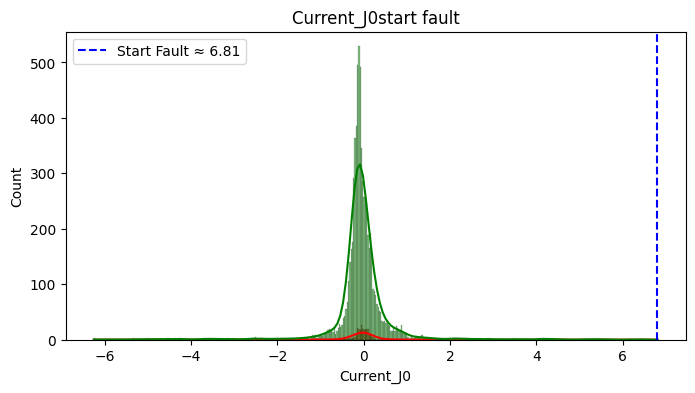

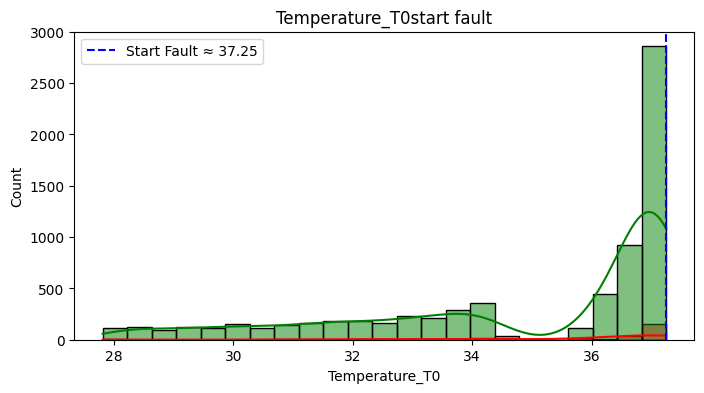

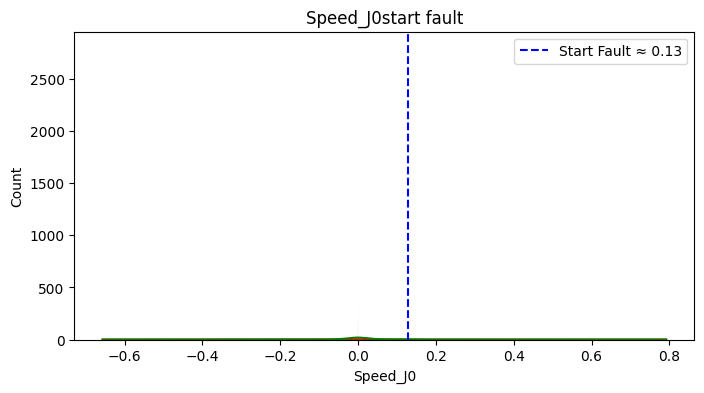

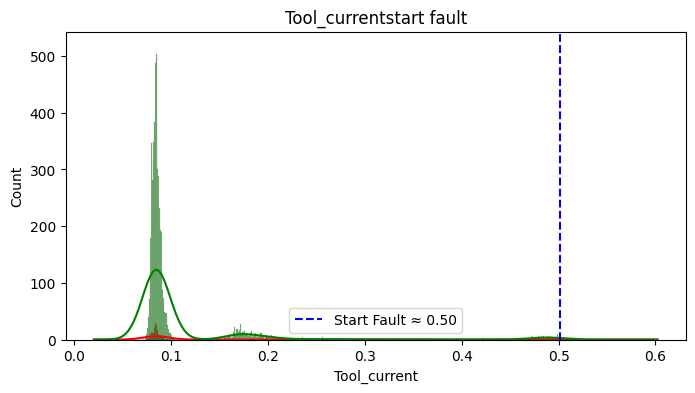

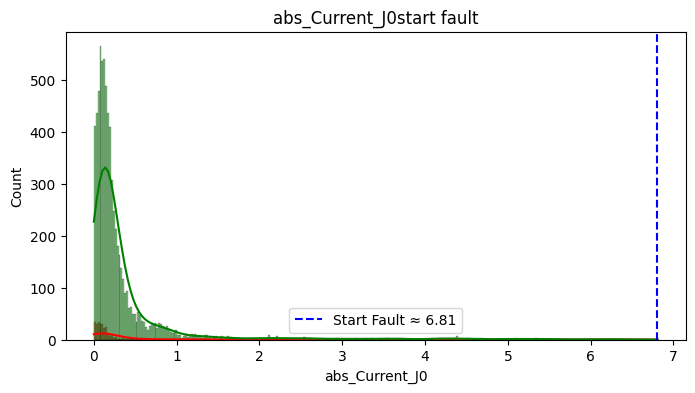

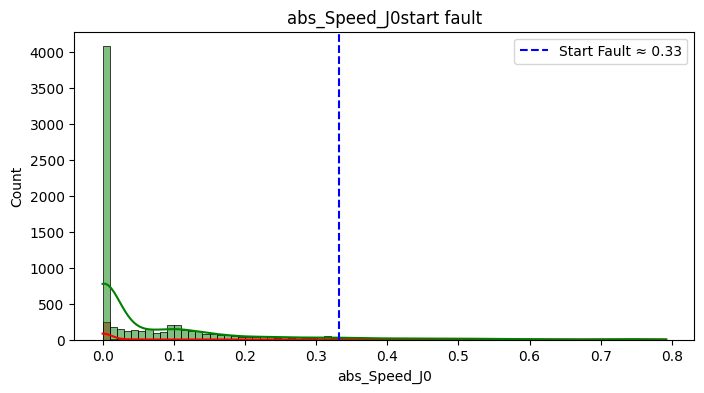

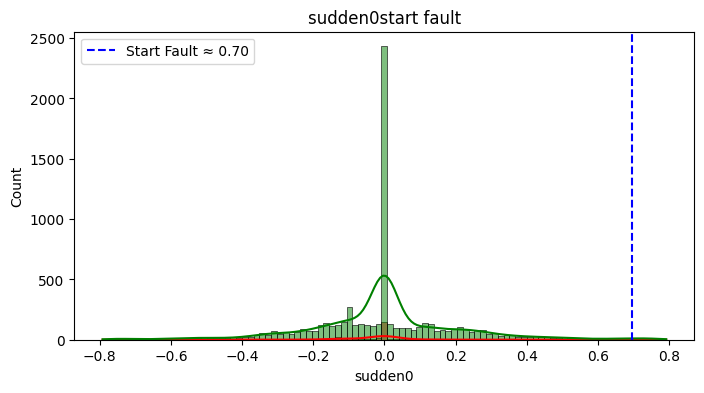

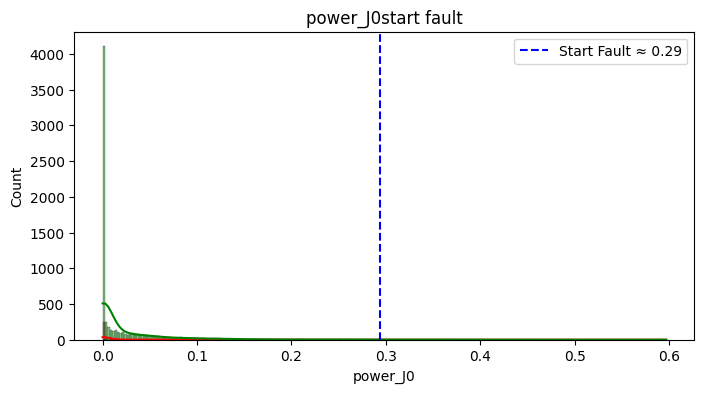

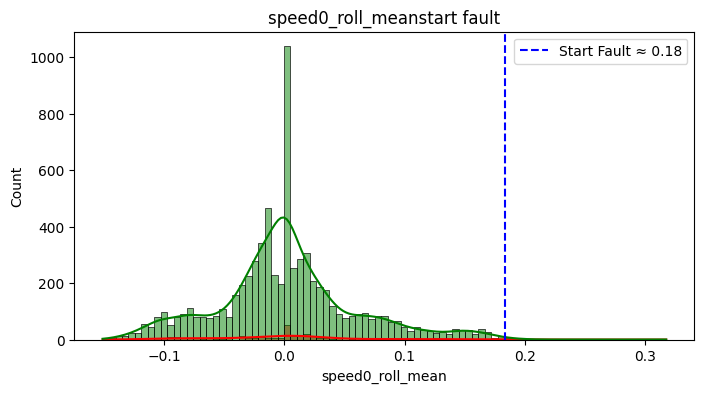

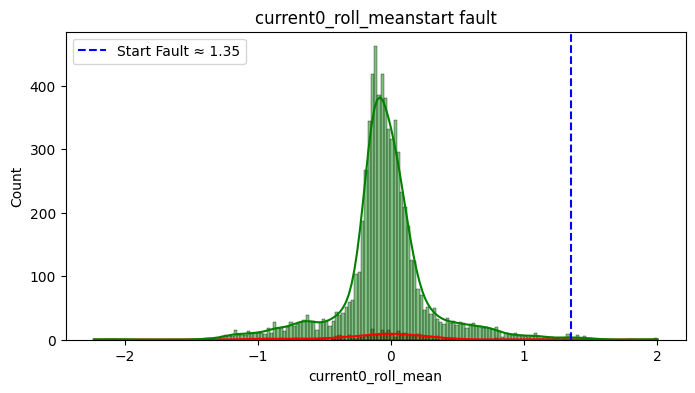

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

thresholds_start = {}

for col in features:
    fault_values = df_joint0_stop_clean[df_joint0_stop_clean["Robot_ProtectiveStop"]==1][col]
    normal_values = df_joint0_stop_clean[df_joint0_stop_clean["Robot_ProtectiveStop"]==0][col]
    
    # أول قيمة Fault أبعد من الميديان بتاع Normal
    start_fault = fault_values.min() if fault_values.min() > normal_values.max() else fault_values.max()
    
    thresholds_start[col] = start_fault

thresholds_start

for col in features:
    plt.figure(figsize=(8,4))
    sns.histplot(data=df_joint0_stop_clean, x=col, hue="Robot_ProtectiveStop", kde=True,
                 palette={0:"green",1:"red"}, alpha=0.5)
    plt.axvline(thresholds_start[col], color="blue", linestyle="--", 
                label=f"Start Fault ≈ {thresholds_start[col]:.2f}")
    plt.title(f"{col}start fault")
    plt.legend()
    plt.show()


In [ ]:
ros=RandomUnderSampler(random_state=42)
X_res, y_res = ros.fit_resample(df_joint0_stop_clean[features], df_joint0_stop_clean["Robot_ProtectiveStop"])
df_resampled = pd.DataFrame(X_res, columns=features)
df_resampled["Robot_ProtectiveStop"] = y_res
df_resampled

d:\Robo-Fault\venv\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
d:\Robo-Fault\venv\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Current_J0  Temperature_T0      Speed_J0  Tool_current  \
cycle                                                                
258   7223    0.397116         37.1250 -2.913100e-02      0.081880   
83    2221   -0.022519         33.6250 -2.714252e-03      0.192636   
36    940     0.190574         30.9375  0.000000e+00      0.087652   
181   4463   -0.007722         36.8750  0.000000e+00      0.175493   
215   5483   -0.011513         37.0625  0.000000e+00      0.087652   
...                ...             ...           ...           ...   
261   7289    0.213052         37.1875 -1.530000e-18      0.085785   
264   7368   -0.100516         37.1875 -1.634530e-04      0.078740   
      7373    0.116355         37.1875 -8.620000e-05      0.081459   
      7375    0.041588         37.1250  1.563657e-02      0.084426   
      7376    0.190994         37.1250 -3.327710e-04      0.081287   

            abs_Current_J0  abs_Speed_J0   sudden0      power_J0  \
cycle                                                              
258   7223        0.397116  2.913100e-02 -0.029131  1.156839e-02   
83    2221        0.022519  2.714252e-03 -0.215658  6.112189e-05   
36    940         0.190574  0.000000e+00  0.000022  0.000000e+00   
181   4463        0.007722  0.000000e+00  0.000000  0.000000e+00   
215   5483        0.011513  0.000000e+00  0.000000  0.000000e+00   
...                    ...           ...       ...           ...   
261   7289        0.213052  1.530000e-18 -0.136488  3.259698e-19   
264   7368        0.100516  1.634530e-04 -0.096268  1.642969e-05   
      7373        0.116355  8.620000e-05 -0.094812  1.002983e-05   
      7375        0.041588  1.563657e-02  0.015637  6.502976e-04   
      7376        0.190994  3.327710e-04 -0.015969  6.355732e-05   

            speed0_roll_mean  current0_roll_mean  Robot_ProtectiveStop  
cycle                                                                   
258   7223          0.054869           -0.807195                   0.0  
83    2221         -0.015650            0.248227                   0.0  
36    940          -0.099176            0.434355                   0.0  
181   4463          0.037328           -0.089533                   0.0  
215   5483         -0.000074           -0.033340                   0.0  
...                      ...                 ...                   ...  
261   7289         -0.099452           -0.170869                   1.0  
264   7368         -0.066526           -0.301016                   1.0  
      7373          0.017745            0.259803                   1.0  
      7375          0.020659            0.232465                   1.0  
      7376          0.021989            0.284743                   1.0  

[558 rows x 11 columns]

In [ ]:
def get_joint_features(df, joint_num):
    """
    Extract feature names for a given joint number from the dataframe.
    Example: joint_num=0 -> ['Current_J0', 'Temperature_J0', 'Speed_J0', ...]
    """
    return [col for col in df.columns if f"_J{joint_num}" in col]

In [ ]:
features_j0 = get_joint_features(df_joint0_grip_clean, 0)
features_j1 = get_joint_features(df_joint1, 1)
features_j2 = get_joint_features(df_joint2, 2)
features_j3 = get_joint_features(df_joint3, 3)
features_j4 = get_joint_features(df_joint4, 4)
features_j5 = get_joint_features(df_joint5, 5)

In [ ]:
def resample_data(df, features, target, random_state=42):
   
    ros = RandomUnderSampler(random_state=random_state)
    X_res, y_res = ros.fit_resample(df[features], df[target])
    df_resampled = pd.DataFrame(X_res, columns=features)
    df_resampled[target] = y_res
    return df_resampled

In [ ]:
joint0_resample_stop=resample_data(df_joint0_stop_clean, features_j0, "Robot_ProtectiveStop", random_state=42)
joint0_resample_grip=resample_data(df_joint0_grip_clean, features_j0, "grip_lost", random_state=42)
joint1_resample_stop=resample_data(df_joint1, features_j1, "Robot_ProtectiveStop", random_state=42)
joint1_resample_grip=resample_data(df_joint1, features_j1, "grip_lost", random_state=42)
joint2_resample_stop=resample_data(df_joint2, features_j2, "Robot_ProtectiveStop", random_state=42)
joint2_resample_grip=resample_data(df_joint2, features_j2, "grip_lost", random_state=42)
joint3_resample_stop=resample_data(df_joint3, features_j3, "Robot_ProtectiveStop", random_state=42)
joint3_resample_grip=resample_data(df_joint3, features_j3, "grip_lost", random_state=42)
joint4_resample_stop=resample_data(df_joint4, features_j4, "Robot_ProtectiveStop", random_state=42)
joint4_resample_grip=resample_data(df_joint4, features_j4, "grip_lost", random_state=42)
joint5_resample_stop=resample_data(df_joint5, features_j5, "Robot_ProtectiveStop", random_state=42)
joint5_resample_grip=resample_data(df_joint5, features_j5, "grip_lost", random_state=42)

d:\Robo-Fault\venv\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
d:\Robo-Fault\venv\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
d:\Robo-Fault\venv\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
d:\Robo-Fault\venv\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
d:\Robo-Fault\venv\lib\site-packages\sklearn\base.py:484: Future

In [ ]:

def train_evaluate_protective_xgboost(df, features, target="Robot_ProtectiveStop", test_size=0.2, random_state=42):
    """
    Split data, train XGBoost model, and evaluate performance.
    
    Parameters:
        df (pd.DataFrame): Input dataframe
        features (list): List of feature column names
        target (str): Target column name (default="Robot_ProtectiveStop")
        test_size (float): Test size for split (default=0.2)
        random_state (int): Random seed
    
    Returns:
        model (XGBClassifier), feature importance dataframe
    """
    
    # === Step 1: Split ===
    X_train, X_test, y_train, y_test = train_test_split(
        df[features], 
        df[target], 
        test_size=test_size, 
        random_state=random_state, 
        stratify=df[target]
    )
    
    # === Step 2: Train XGBoost ===
    xgb_model = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric="logloss"
    )
    
    xgb_model.fit(X_train, y_train)
    
    # === Step 3: Evaluate ===
    y_pred = xgb_model.predict(X_test)
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    # === Step 4: Feature importance ===
    importances = xgb_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        "Feature": features,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)
    
    return xgb_model, feature_importance_df

In [ ]:

def train_evaluate_grip_xgboost(df, features, target="grip_lost", test_size=0.2, random_state=42):

    
    # === Step 1: Split ===
    X_train, X_test, y_train, y_test = train_test_split(
        df[features], 
        df[target], 
        test_size=test_size, 
        random_state=random_state, 
        stratify=df[target]
    )
    
    # === Step 2: Train XGBoost ===
    xgb_model = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric="logloss"
    )
    
    xgb_model.fit(X_train, y_train)
    
    # === Step 3: Evaluate ===
    y_pred = xgb_model.predict(X_test)
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    # === Step 4: Feature importance ===
    importances = xgb_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        "Feature": features,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)
    
    return xgb_model, feature_importance_df

In [ ]:
train_evaluate_protective_xgboost(joint0_resample_stop, features_j0)


d:\Robo-Fault\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [08:43:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6160714285714286

Classification Report:
               precision    recall  f1-score   support

         0.0       0.61      0.64      0.63        56
         1.0       0.62      0.59      0.61        56

    accuracy                           0.62       112
   macro avg       0.62      0.62      0.62       112
weighted avg       0.62      0.62      0.62       112


Confusion Matrix:
 [[36 20]
 [23 33]]


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.05, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=300,
               n_jobs=-1, num_parallel_tree=None, random_state=42, ...),
           Feature  Importance
 4        power_J0    0.249547
 3    abs_Speed_J0    0.243507
 1        Speed_J0    0.181871
 2  abs_Current_J0    0.170216
 0      Current_J0    0.154858)

In [ ]:
train_evaluate_grip_xgboost(joint0_resample_grip, features_j0)

d:\Robo-Fault\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [08:43:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7142857142857143

Classification Report:
               precision    recall  f1-score   support

       False       0.72      0.69      0.71        49
        True       0.71      0.73      0.72        49

    accuracy                           0.71        98
   macro avg       0.71      0.71      0.71        98
weighted avg       0.71      0.71      0.71        98


Confusion Matrix:
 [[34 15]
 [13 36]]


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.05, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=300,
               n_jobs=-1, num_parallel_tree=None, random_state=42, ...),
           Feature  Importance
 4        power_J0    0.223032
 3    abs_Speed_J0    0.220254
 2  abs_Current_J0    0.199770
 1        Speed_J0    0.196918
 0      Current_J0    0.160026)

In [ ]:
train_evaluate_protective_xgboost(joint1_resample_stop, features_j1)

Accuracy: 0.75

Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.75      0.75        56
         1.0       0.75      0.75      0.75        56

    accuracy                           0.75       112
   macro avg       0.75      0.75      0.75       112
weighted avg       0.75      0.75      0.75       112


Confusion Matrix:
 [[42 14]
 [14 42]]


d:\Robo-Fault\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [08:43:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.05, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=300,
               n_jobs=-1, num_parallel_tree=None, random_state=42, ...),
           Feature  Importance
 0      Current_J1    0.212875
 5        power_J1    0.169976
 3  abs_Current_J1    0.163750
 1  Temperature_J1    0.156176
 4    abs_Speed_J1    0.153158
 2        Speed_J1    0.144065)

In [ ]:
train_evaluate_grip_xgboost(joint1_resample_grip, features_j1)

d:\Robo-Fault\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [08:44:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7653061224489796

Classification Report:
               precision    recall  f1-score   support

       False       0.76      0.78      0.77        49
        True       0.77      0.76      0.76        49

    accuracy                           0.77        98
   macro avg       0.77      0.77      0.77        98
weighted avg       0.77      0.77      0.77        98


Confusion Matrix:
 [[38 11]
 [12 37]]


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.05, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=300,
               n_jobs=-1, num_parallel_tree=None, random_state=42, ...),
           Feature  Importance
 1  Temperature_J1    0.201749
 2        Speed_J1    0.172615
 4    abs_Speed_J1    0.167413
 5        power_J1    0.157401
 3  abs_Current_J1    0.152556
 0      Current_J1    0.148266)

In [ ]:
train_evaluate_protective_xgboost(joint2_resample_stop, features_j2)

Accuracy: 0.8125

Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.86      0.82        56
         1.0       0.84      0.77      0.80        56

    accuracy                           0.81       112
   macro avg       0.82      0.81      0.81       112
weighted avg       0.82      0.81      0.81       112


Confusion Matrix:
 [[48  8]
 [13 43]]


d:\Robo-Fault\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [08:44:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.05, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=300,
               n_jobs=-1, num_parallel_tree=None, random_state=42, ...),
           Feature  Importance
 4    abs_Speed_J2    0.221329
 0      Current_J2    0.209235
 3  abs_Current_J2    0.172965
 2        Speed_J2    0.139159
 5        power_J2    0.137680
 1  Temperature_J2    0.119632)

In [ ]:
train_evaluate_grip_xgboost(joint2_resample_grip, features_j2)

d:\Robo-Fault\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [08:45:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7346938775510204

Classification Report:
               precision    recall  f1-score   support

       False       0.73      0.76      0.74        49
        True       0.74      0.71      0.73        49

    accuracy                           0.73        98
   macro avg       0.74      0.73      0.73        98
weighted avg       0.74      0.73      0.73        98


Confusion Matrix:
 [[37 12]
 [14 35]]


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.05, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=300,
               n_jobs=-1, num_parallel_tree=None, random_state=42, ...),
           Feature  Importance
 1  Temperature_J2    0.249086
 0      Current_J2    0.178816
 3  abs_Current_J2    0.147506
 5        power_J2    0.143084
 2        Speed_J2    0.141002
 4    abs_Speed_J2    0.140506)

In [ ]:
train_evaluate_protective_xgboost(joint3_resample_stop, features_j3)

Accuracy: 0.8571428571428571

Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.89      0.86        56
         1.0       0.88      0.82      0.85        56

    accuracy                           0.86       112
   macro avg       0.86      0.86      0.86       112
weighted avg       0.86      0.86      0.86       112


Confusion Matrix:
 [[50  6]
 [10 46]]


d:\Robo-Fault\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [08:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.05, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=300,
               n_jobs=-1, num_parallel_tree=None, random_state=42, ...),
           Feature  Importance
 3  abs_Current_J3    0.214839
 4    abs_Speed_J3    0.200994
 2        Speed_J3    0.158455
 0      Current_J3    0.158052
 5        power_J3    0.140505
 1  Temperature_J3    0.127153)

In [ ]:
train_evaluate_grip_xgboost(joint3_resample_grip, features_j3)

Accuracy: 0.7959183673469388

Classification Report:
               precision    recall  f1-score   support

       False       0.78      0.82      0.80        49
        True       0.81      0.78      0.79        49

    accuracy                           0.80        98
   macro avg       0.80      0.80      0.80        98
weighted avg       0.80      0.80      0.80        98


Confusion Matrix:
 [[40  9]
 [11 38]]


d:\Robo-Fault\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [08:46:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.05, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=300,
               n_jobs=-1, num_parallel_tree=None, random_state=42, ...),
           Feature  Importance
 1  Temperature_J3    0.193197
 2        Speed_J3    0.190744
 0      Current_J3    0.160364
 4    abs_Speed_J3    0.158499
 3  abs_Current_J3    0.152730
 5        power_J3    0.144466)

In [ ]:
train_evaluate_protective_xgboost(joint4_resample_stop, features_j4)

Accuracy: 0.7053571428571429

Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.73      0.71        56
         1.0       0.72      0.68      0.70        56

    accuracy                           0.71       112
   macro avg       0.71      0.71      0.71       112
weighted avg       0.71      0.71      0.71       112


Confusion Matrix:
 [[41 15]
 [18 38]]


d:\Robo-Fault\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [08:46:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.05, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=300,
               n_jobs=-1, num_parallel_tree=None, random_state=42, ...),
           Feature  Importance
 4    abs_Speed_J4    0.278075
 2        Speed_J4    0.171220
 1  Temperature_J4    0.163608
 5        power_J4    0.135347
 0      Current_J4    0.130828
 3  abs_Current_J4    0.120922)

In [ ]:
train_evaluate_grip_xgboost(joint4_resample_grip, features_j4)

Accuracy: 0.7857142857142857

Classification Report:
               precision    recall  f1-score   support

       False       0.80      0.76      0.78        49
        True       0.77      0.82      0.79        49

    accuracy                           0.79        98
   macro avg       0.79      0.79      0.79        98
weighted avg       0.79      0.79      0.79        98


Confusion Matrix:
 [[37 12]
 [ 9 40]]


d:\Robo-Fault\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [08:46:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.05, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=300,
               n_jobs=-1, num_parallel_tree=None, random_state=42, ...),
           Feature  Importance
 1  Temperature_J4    0.195416
 2        Speed_J4    0.192676
 5        power_J4    0.181207
 0      Current_J4    0.148327
 3  abs_Current_J4    0.144289
 4    abs_Speed_J4    0.138084)

In [ ]:
train_evaluate_protective_xgboost(joint5_resample_stop, features_j5)

Accuracy: 0.7857142857142857

Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.79      0.79        56
         1.0       0.79      0.79      0.79        56

    accuracy                           0.79       112
   macro avg       0.79      0.79      0.79       112
weighted avg       0.79      0.79      0.79       112


Confusion Matrix:
 [[44 12]
 [12 44]]


d:\Robo-Fault\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [08:47:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.05, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=300,
               n_jobs=-1, num_parallel_tree=None, random_state=42, ...),
           Feature  Importance
 5        power_J5    0.239425
 0      Current_J5    0.204771
 4    abs_Speed_J5    0.197139
 1  Temperature_J5    0.130631
 2        Speed_J5    0.116678
 3  abs_Current_J5    0.111355)

In [ ]:
train_evaluate_grip_xgboost(joint5_resample_grip, features_j5)

d:\Robo-Fault\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [08:47:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7653061224489796

Classification Report:
               precision    recall  f1-score   support

       False       0.77      0.76      0.76        49
        True       0.76      0.78      0.77        49

    accuracy                           0.77        98
   macro avg       0.77      0.77      0.77        98
weighted avg       0.77      0.77      0.77        98


Confusion Matrix:
 [[37 12]
 [11 38]]


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.05, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=300,
               n_jobs=-1, num_parallel_tree=None, random_state=42, ...),
           Feature  Importance
 1  Temperature_J5    0.234089
 2        Speed_J5    0.230429
 3  abs_Current_J5    0.142513
 5        power_J5    0.132442
 0      Current_J5    0.131398
 4    abs_Speed_J5    0.129128)